# Final Notebook

# Importing Datasets and Data Cleaning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

import pydicom as dicom
from random import randint
import os, sys, time, shutil, scipy, cv2, json, datetime, pydicom
from tqdm.notebook import tqdm
from skimage import io
from glob import glob
import albumentations as A
from PIL import Image
from skimage.color import label2rgb
import random

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import models, layers, regularizers, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split

%reload_ext autoreload
%autoreload 2
from utils import *

## 2020 Training Dataset

In [3]:
# load metadata for 2020 training dataset and change column names
train20 = pd.read_csv('data/ISIC_2020_Training_GroundTruth_v2.csv')
train20.columns = ['file', 'patient_id', 'lesion_id', 'gender', 'age', 'site', 'diagnosis', 'ben_mal', 'target']
train20.head()

file  patient_id   lesion_id  gender   age             site  \
0  ISIC_2637011  IP_7279968  IL_7972535    male  45.0        head/neck   
1  ISIC_0015719  IP_3075186  IL_4649854  female  45.0  upper extremity   
2  ISIC_0052212  IP_2842074  IL_9087444  female  50.0  lower extremity   
3  ISIC_0068279  IP_6890425  IL_4255399  female  45.0        head/neck   
4  ISIC_0074268  IP_8723313  IL_6898037  female  55.0  upper extremity   

  diagnosis ben_mal  target  
0   unknown  benign       0  
1   unknown  benign       0  
2     nevus  benign       0  
3   unknown  benign       0  
4   unknown  benign       0

In [4]:
# display target count for dataset
train20.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

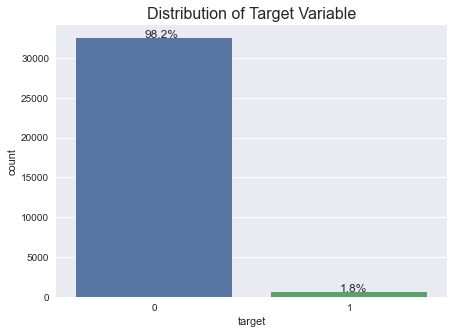

In [5]:
# make visualization to demonstrate class imbalance
def barplot(plot, feature, title):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.title(title, fontsize=16)
    plt.show()

plt.figure(figsize= (7,5))
ax = sns.countplot(x='target', data=train20)
barplot(ax, train20.target, "Distribution of Target Variable")

## 2019 Training Dataset

This training dataset compiles the images from the following datasets:  BCN_2000, HAM1000, and MSK.  25,331 images were available for training across 8 different categories.  The metadata contains information about the age and gender of the patient, as well as the lesion ID and anatomical site.  There are 8 diagnostic categories:  Melanoma, nevus, basal cell carcinoma, acitinic keratosis, benign keratosis, deramtofibroma, vascular lession, squamous cell carcinoma, and unknown.

We subset the melanoma images and inserted them as additional samples of the minority class into our original dataset.

**Additional melanoma images:**  4522 

In [6]:
# Upload 2019 Training metadata to determine any additional instances of minority class
train19a = pd.read_csv('data/ISIC_2019_Training_GroundTruth.csv')
train19b = pd.read_csv('data/ISIC_2019_Training_Metadata.csv')
train19a = train19a.rename(columns={'image':'image1'})
train19b = train19b.rename(columns={'image':'image2'})
train19 = pd.concat([train19b, train19a], axis=1)
train19 = train19.drop(columns=['image1', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
train19.columns = ['file', 'age', 'site', 'lesion_id', 'gender', 'target']
train19.target = train19.target.astype(int)
train19.head()

file   age             site lesion_id  gender  target
0  ISIC_0000000  55.0   anterior torso       NaN  female       0
1  ISIC_0000001  30.0   anterior torso       NaN  female       0
2  ISIC_0000002  60.0  upper extremity       NaN  female       1
3  ISIC_0000003  30.0  upper extremity       NaN    male       0
4  ISIC_0000004  80.0  posterior torso       NaN    male       1

In [7]:
# Display target count for 2019 Training Dataset
train19.target.value_counts()

0    20809
1     4522
Name: target, dtype: int64

## Combining Dataframes

In [8]:
train19_mel = train19[train19.target == 1]
train = pd.concat([train20, train19_mel], axis=0, ignore_index=True)
train.head()

file  patient_id   lesion_id  gender   age             site  \
0  ISIC_2637011  IP_7279968  IL_7972535    male  45.0        head/neck   
1  ISIC_0015719  IP_3075186  IL_4649854  female  45.0  upper extremity   
2  ISIC_0052212  IP_2842074  IL_9087444  female  50.0  lower extremity   
3  ISIC_0068279  IP_6890425  IL_4255399  female  45.0        head/neck   
4  ISIC_0074268  IP_8723313  IL_6898037  female  55.0  upper extremity   

  diagnosis ben_mal  target  
0   unknown  benign       0  
1   unknown  benign       0  
2     nevus  benign       0  
3   unknown  benign       0  
4   unknown  benign       0

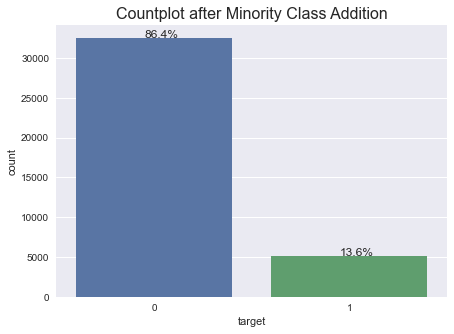

In [10]:
# display new target variable distribution
plt.figure(figsize= (7,5))
ax = sns.countplot(x='target', data=train)
barplot(ax, train.target, "Countplot after Minority Class Addition")

## Validation and Testing Set

Originally we used a different dataset for our testing set, but we switched to splitting the validation set into a validation and testing set.  We will use the additional dataset as a second testing set to ensure further generalizability of model.  The code for splitting of the images into the validation and testing sets is located in the `folder.ipynb` file.  So this EDA below is for the training set from the 2020 competition set and testing set from the 2017 competition set.

In [11]:
test1 = pd.read_csv('data/ISIC-2017_Training_Data_metadata.csv')
test1.columns = ['file', 'age', 'gender']
test1 = test1.replace({'age': 'unknown'}, np.nan)
test1 = test1.replace({'gender': 'unknown'}, np.nan)
test2 = pd.read_csv('data/ISIC-2017_Training_Part3_GroundTruth.csv')
test2 = test2.drop(columns=['seborrheic_keratosis'], axis=1)
test2.columns = ['file1', 'target']
test2.target = test2.target.astype(int)
test = pd.concat([test1, test2], axis=1)
test = test.drop(columns=['file1'], axis=1)
test.target.value_counts()

0    1626
1     374
Name: target, dtype: int64

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    2000 non-null   object
 1   age     1744 non-null   object
 2   gender  1771 non-null   object
 3   target  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


# Exploratory Data Analysis

For additional visualizations, please refer to the `EDA.ipynb` notebook.

I filled in the missing values in the training set when I was still thinking of combining the metadata and the image data into an ensemble method, which would require me to fill in missing values.  I left it out in the final notebook, as well as the visualizations comparing the testing and training dataset.  I chose to go with the 2017 dataset as the testing dataset, and it had much fewer columns than the 2020 testing dataset.  The 2020 testing dataset did not have labels, so I went with the 2017 dataset.

## Gender Distribution

Text(0.5, 1.0, 'Gender Distribution of Melanoma Patients')

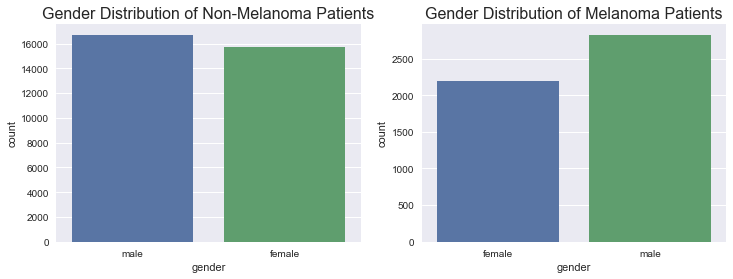

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='gender', data=train[train.target == 0], ax=ax1)
b = sns.countplot(x='gender', data=train[train.target == 1], ax=ax2)
ax1.set_title("Gender Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Gender Distribution of Melanoma Patients", fontsize=16)

Text(0.5, 1.0, 'Gender Distribution of Testing Set')

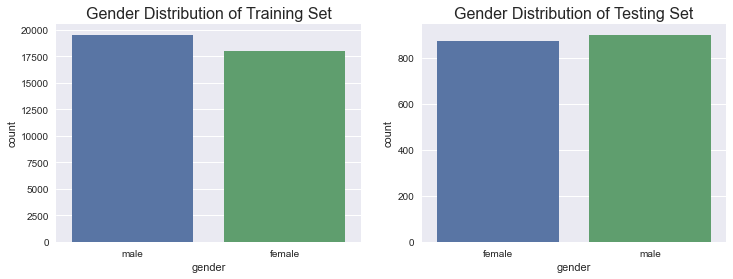

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='gender', data=train, ax=ax1)
b = sns.countplot(x='gender', data=test, ax=ax2)
ax1.set_title("Gender Distribution of Training Set", fontsize=16)
ax2.set_title("Gender Distribution of Testing Set", fontsize=16)

## Age Distribution

Text(0.5, 1.0, 'Age Distribution of Melanoma Patients')

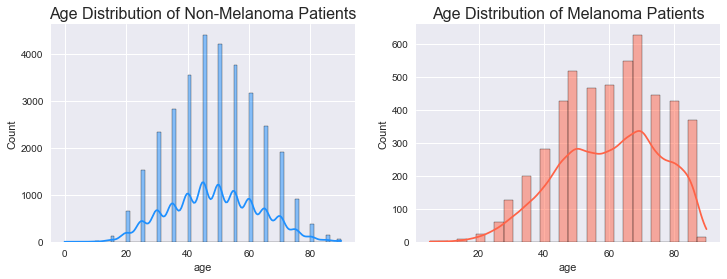

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='age', data=train[train.target == 0], kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='age', data=train[train.target == 1], kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Age Distribution of Melanoma Patients", fontsize=16)

In [16]:
test.age = test[~test.age.isna()].age.astype(int)

Text(0.5, 1.0, 'Age Distribution of Testing Dataset')

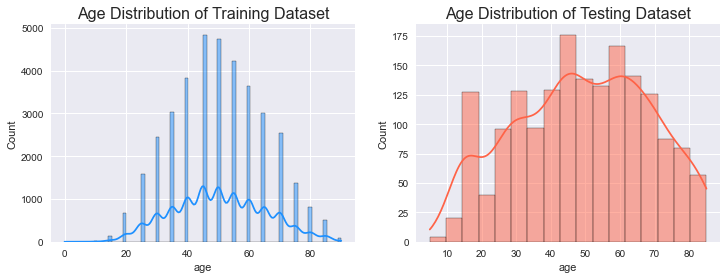

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='age', data=train, kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='age', data=test[~test.age.isna()], kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Training Dataset", fontsize=16)
ax2.set_title("Age Distribution of Testing Dataset", fontsize=16)

## Site Distribution

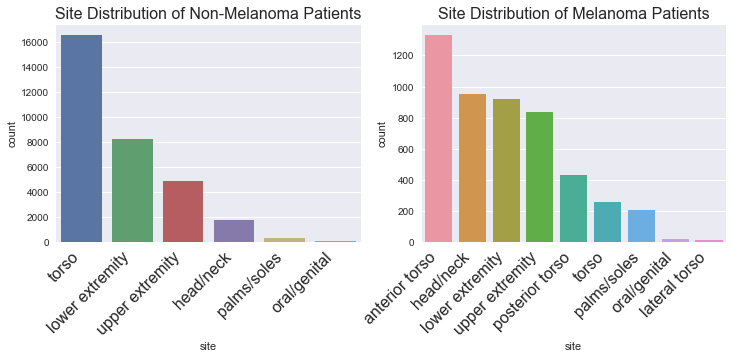

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='site', data=train[train.target == 0], order = train[train.target == 0]['site'].value_counts().index, ax=ax1)
b = sns.countplot(x='site', data=train[train.target == 1], order = train[train.target == 1]['site'].value_counts().index, ax=ax2)
ax1.set_title("Site Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Site Distribution of Melanoma Patients", fontsize=16)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=16, ha='right')

## Diagnosis Distribution

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'nevus'),
  Text(1, 0, 'melanoma'),
  Text(2, 0, 'seborrheic keratosis'),
  Text(3, 0, 'lentigo NOS'),
  Text(4, 0, 'lichenoid keratosis'),
  Text(5, 0, 'solar lentigo'),
  Text(6, 0, 'cafe-au-lait macule'),
  Text(7, 0, 'atypical melanocytic proliferation')])

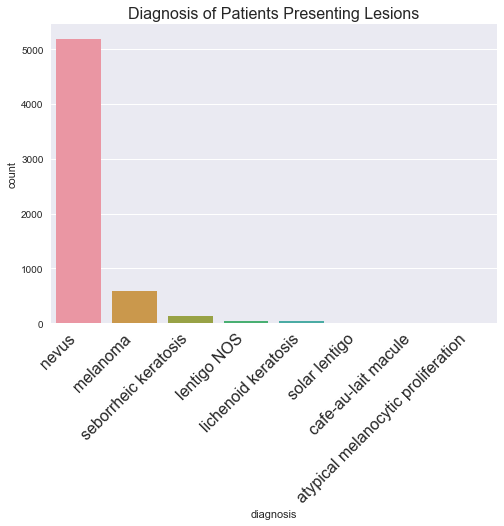

In [19]:
train_diag = train[train.diagnosis != 'unknown']
sns.countplot(x='diagnosis', data=train_diag)
plt.title("Diagnosis of Patients Presenting Lesions", fontsize=16)
plt.xticks(rotation=45, fontsize=16, ha='right')

## Visualizing Melanoma, Non-melanoma and Transformations

To the layman, we can use the ABCDE's of Skin Cancer to identify what to look for in scanning for potential melanomas.  Just as a reminder:

1. Asymmetry
2. Border
3. Color
4. Diameter
5. Evolving

So that means a mole that is asymmetric, uneven in borders, varied in color (black, tan, or brown), larger in diameter than a pencil eraser, and/or evolving in size, shape, or color would be indicative of melanoma, and you should get it checked out immediately.


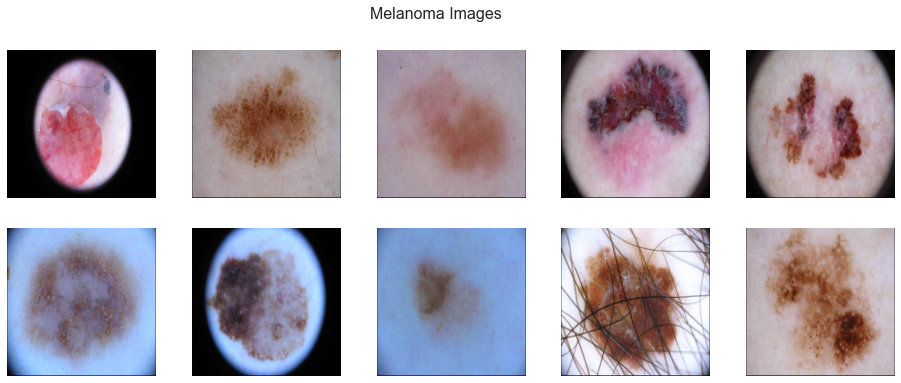

In [20]:
paths = glob('split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Melanoma Images', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

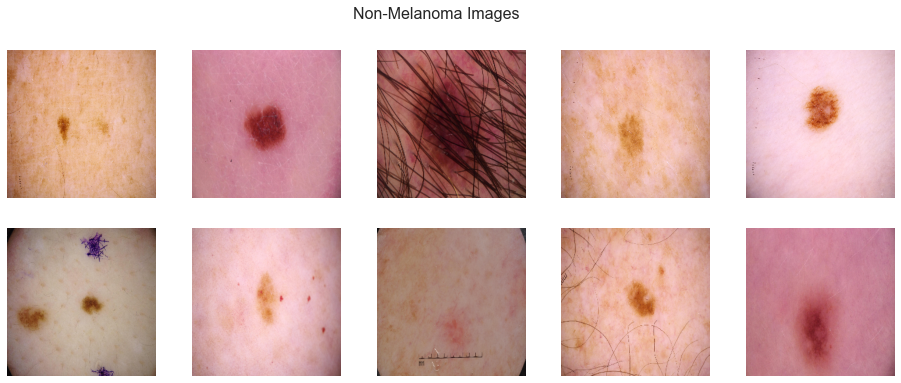

In [21]:
paths = glob('split/train/not_mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Non-Melanoma Images', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

## Albumentations Augmentations

For the entire set of visualizations of the different transformations, please refer to the `albumentation.ipynb` notebook.  Here we have displayed 2 of the transformations.

We also implemented augmentations through DataImageGenerator, please refer to the `augmentation.ipynb` notebook, but it was not producing good metrics in terms of modeling.

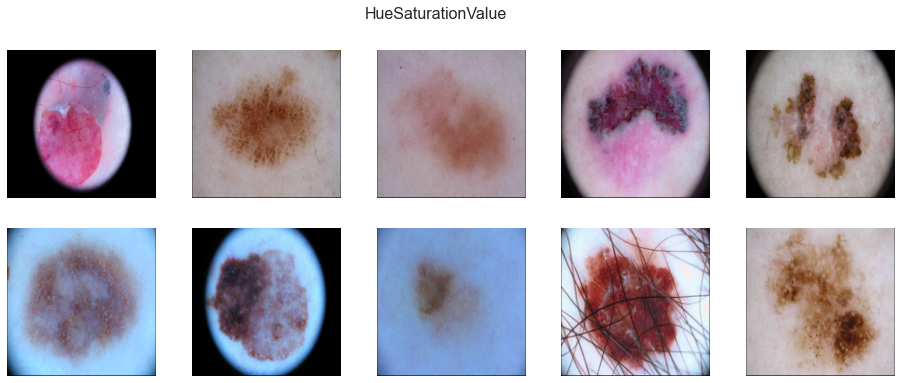

In [22]:
transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10)
])

paths = glob('split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('HueSaturationValue', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

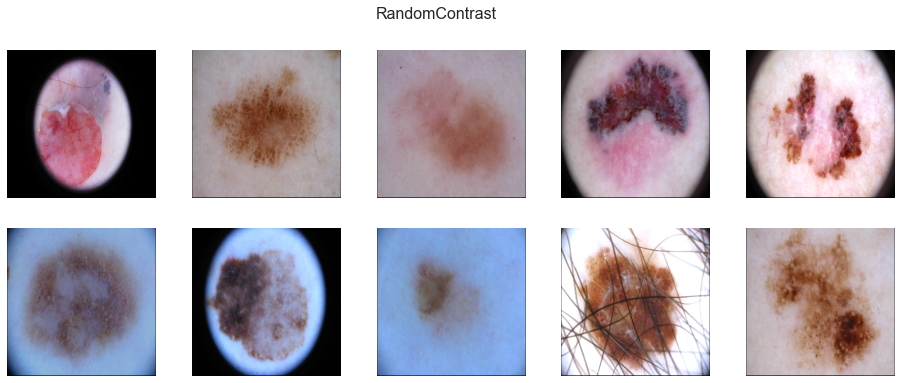

In [23]:
transform = A.Compose([
    A.RandomContrast(limit=0.3)
])

paths = glob('split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('RandomContrast', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

## Code for Producing Transformations

We employed the following transformations in the Albumentations package on all the melanoma images from 2019 and 2020 datasets: 
- Transpose:  transpose input by sqapping rows and columns
- Vertical Flip: flip image vertically aorund x-axis
- Horizontal Flip:  flip input horizontally around y-axis
- CLAHE: apply contrast limited adaptive histogram equalization to input image 
- Cut Out: Coarse Dropout of the square regions in the image
- Gaussian Blur: Blur the input image using Gaussian filter with random kernel size
- Gauss Noise: apply Gaussian noise to input image
- Grid Distortion
- Hue Saturation Value:  randomly change hue, saturation, and value of input image
- Median BLur: blur image using median filter with random aperture linear size
- Motion Blur: apply motion blur to input iamge using random-sized kernel
- Optical Distortion
- Random Brightness: randomly change brightness of input iamge
- Random Contrast: randomly change contrast of input iamge
- Shift Scale Rotate
- Elastic Transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

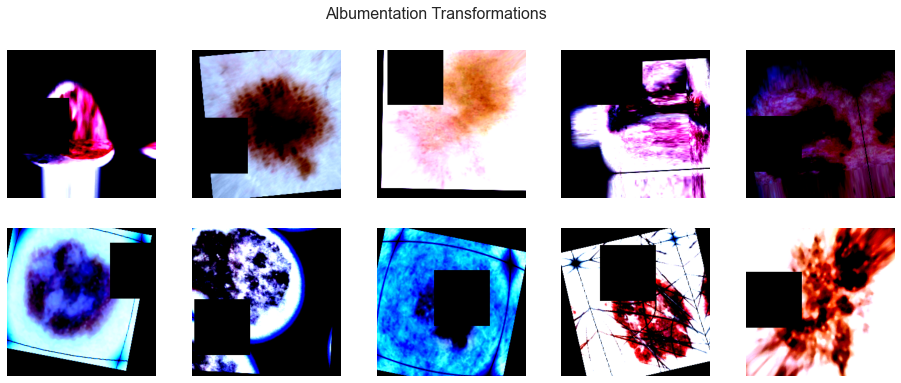

In [24]:
transform = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),
    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.Resize(256, 256),
    A.Cutout(max_h_size=int(256 * 0.375), max_w_size=int(256 * 0.375), num_holes=1, p=0.7),
    A.Normalize()
])

paths = glob('split/train/mel/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('Albumentation Transformations', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

In [25]:
# Code to produce augmented images into separate folder

# paths = glob('../split/train/mel/2020/*.jpg')

# for i in range(0, 467):   
#     f, ax = plt.subplots()
#     image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     transformed = transform(image=image)
#     aug_image = transformed['image']
#     plt.imshow(aug_image)
#     plt.savefig("../split/train/mel/2020_T/aug_image_{}.png".format(i))
#     plt.close('all')

# Folder Management

It is essential that your folders are organized in a particular way before embarking on the modeling process.  Please refer to the `folders.ipynb` notebook for the complete code of the somewhat tedious process of moving the image files into the proper folders.  The code is not very elegant, but it got the job done.  I found that splitting images into batches of 2000 worked a lot faster than doing the entire 20,000 images, let's say, in the folder.

Here is the folder structure we employed before embarking on the modeling process:

- `split`
    - `train`
        - `mel`
            - `aug`
        - `not_mel`
    - `val`
        - `mel`
        - `not_mel`
    - `test`
        - `mel`
        - `not_mel`
    - `train_imb`
        - `mel`
        - `not_mel`
- `sample`
    - `train`
        - `mel`
        - `not_mel`
    - `val`
        - `mel`
        - `not_mel`
    - `test`
        - `mel`
        - `not_mel`

`train_imb` contains the original dataset without the added melanoma images and the augmentations.

# Train-Validation-Test Split

We performed a 80/20 split on the training set initially for the training and validation set before adding any additional minority class instances and augmentations, and decided to use another dataset as the testing set because we did not want to remove any more training data.  While the 2020 testing dataset did not have labels, the 2017 training set of 2000 images had labels attached.  There were concerns that my validation metrics were so much higher than my training metrics through the modeling proess.

We ended up redoing the training and validation split after minority class additions but before augmentations for a less imbalanced validation set.

An additional change we ultimately made was to form our testing set from our validation set after minority class additions but before any augmentations.

In [26]:
# Train-Validation Split
df = pd.read_csv('data/tr_tot.csv')
melanoma = df[df.target == 1]
non_melanoma = df[df.target == 0]
y_mel = melanoma.target
X_mel = melanoma.drop(columns=['target'], axis=1)
y_non_mel = non_melanoma.target
X_non_mel = non_melanoma.drop(columns=['target'], axis=1)

X_tr_m, X_val_m, y_tr_m, y_val_m = train_test_split(X_mel, y_mel, random_state=42, test_size=0.2)
X_tr_nm, X_val_nm, y_tr_nm, y_val_nm = train_test_split(X_non_mel, y_non_mel, random_state=42, test_size=0.2)

mel_train = pd.concat([X_tr_m, y_tr_m], axis=1)
non_mel_train = pd.concat([X_tr_nm, y_tr_nm], axis=1)
mel_val = pd.concat([X_val_m, y_val_m], axis=1)
non_mel_val = pd.concat([X_val_nm, y_val_nm], axis=1)

train = pd.concat([mel_train, non_mel_train], axis=0)
val = pd.concat([mel_val, non_mel_val], axis=0)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

train = train[['file', 'target']]
val = val[['file', 'target']]

train.head()

file  target
0              ISIC_0065823       1
1  ISIC_0013908_downsampled       1
2              ISIC_0054089       1
3              ISIC_0061371       1
4              ISIC_8702237       1

In [27]:
val.head()

file  target
0  ISIC_0066225       1
1  ISIC_0000013       1
2  ISIC_9367522       1
3  ISIC_3969411       1
4  ISIC_0026531       1

## Forming Training Dataset

In [28]:
# Make new directories and assign directory variables
new_dir = 'split/'
# os.mkdir(new_dir)

#.Make subfolders for melanoma and non-melanoma images
tr_fldr = os.path.join(new_dir, 'train')
tr_mel = os.path.join(tr_fldr, 'mel')
tr_nm = os.path.join(tr_fldr, 'not_mel')

# os.mkdir(tr_fldr)
# os.mkdir(tr_mel)
# os.mkdir(tr_nm)

# separate melanoma from non-melanoma in dataframe
train['jpg'] = train.file.apply(lambda x: str(x) + '.jpg')
mel_train = train[train.target == 1]
non_mel_train = train[train.target == 0]

# turn all image files into a list to insert into for loop
images_dir = 'data/train_jpg'
mel_tr_ids = mel_train.jpg.to_list()
nm_tr_ids = non_mel_train.jpg.to_list()

# move all melanoma images into subfolder
# for img in tqdm (mel_tr_ids):
#     shutil.move(os.path.join(images_dir, img), os.path.join(tr_mel, img))
#.    use shutil.copyfile() if you wish to copy rather than move

# move non-melanoma imgaes into subfolder
# for img in tqdm(nm_tr_ids):
#     shutil.move(os.path.join(images_dir, img), os.path.join(tr_nm, img))

The same process was employed for the validation and testing datasets.  Please refer to the folder.ipynb for complete code.

# Modeling Process

For different iterations of the modeling process, please refer to the modeling.ipynb notebook, as well as modeling2.ipynb notebook. We started with a densely connected network, and then moved to a basic convolutional neural network, but what became apparent with the class imbalance.

# Metrics and Evaluation Process

Throughout the entire modeling process, I looked at the following metrics in our evaluation process, and here is the reasoning behind looking at these metrics:

- **Accuracy** is not useful by itself for extremely imbalanced datasets, since a high Accuracy is easily achieved by just predicting majority class.  It is the default metric for classification algorithms.
- **Precision** tells us how many of the correctly predicted cases actually turned out to be positive. This was the least telling of all the metrics, as it was skewed towards 1.0 in almost all the iterations.  I like to think of this as how many selected items are relevant, where selection is what I labeled as a particular class.  Out of TP and FP, how many were TPs?
- **Recall** tells us how many of the actual positive cases we were able to predict correctly with our model.  Recall is a useful metric in cases where False Negative trumps False Positive.  I remember recall in terms of relevant items (R and R).  Recall is the relevant items retrieved out of total relevant items.  All relevant items are of one class.  So it is concerned with the members of just one class, aka FN and TP, and is not concerned with the other class entirely.
- **ROC-AUC** plots FPR (x-axis) vs. TPR (y-axis), and can be thought of as the fraction of correct predictions versus the fraction of errors for the negative class. It is a measure of the disciminative power between the positive and negative classes. At an AUC score of 0.50, a classifier basically has no discriminative power between the two classes as is the case when there is a FPR and TPR of 0 (predicting all as negative class) or FPR and TPR of 1 (predicting all as positive class), which produces a diagonal line from the lower left to upper right. For imbalanced datasets, this is most commonly used metric to compare classification models.
- **PR-AUC** plots recall (x-axis) vs. precision (y-axis), which are both focused on the positive class and not the negative class. A no-skill classifier would produce a horizontal line close to the x-axis where precision is equal to 0.50.  This metric is useful in imbalanced datasets where ROC/AUC scores are giving overly optimistic scores.


## Augmentation through ImageDataGenerator

ImageDataGenerator randomly creates transformations of the majority as well as the minority class, and as you see below did not produce results that indicated the model was unable to differentiate between the minority and majority class.

In [25]:
train_fldr = "split/train_imb"
val_fldr = "split/val"
test_fldr = "split/test"

tr_gen_imb = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_fldr, 
                                                                     target_size = (224, 224),
                                                                     batch_size = 16)
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_fldr, 
                                                                        target_size = (224, 224),
                                                                        batch_size = 16)
tt_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_fldr,
                                                                       target_size = (224, 224),
                                                                       batch_size = 16)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [27]:
X_tr, y_tr = next(tr_gen_imb)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(tt_generator)

In [32]:
def basic_cnn(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=2, activation='sigmoid')
        ])

model = basic_cnn((224, 244, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [33]:
history = model.fit(X_tr,
                   y_tr,
                   epochs = 50,
                   validation_data = (X_val, y_val))

Epoch 1/50
1/1 [==============================] - 14s 14s/step - loss: 0.7602 - accuracy: 0.6250 - precision_5: 0.7500 - recall_5: 0.3750 - auc_10: 0.6289 - auc_11: 0.6726 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000 - val_auc_10: 1.0000 - val_auc_11: 1.0000
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - auc_10: 1.0000 - auc_11: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000 - val_auc_10: 1.0000 - val_auc_11: 1.0000
Epoch 3/50
1/1 [==============================] - 14s 14s/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - auc_10: 1.0000 - auc_11: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000 - val_auc_10: 1.0000 - val_auc_11: 1.0000
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss

In [41]:
history_df = pd.DataFrame(history.history)
history_df.head(10)

loss  accuracy  precision_5  recall_5    auc_10    auc_11  \
0  7.601700e-01     0.625         0.75     0.375  0.628906  0.672557   
1  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
2  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
3  6.692105e-31     1.000         1.00     1.000  1.000000  1.000000   
4  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
5  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
6  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
7  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
8  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
9  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   

   val_loss  val_accuracy  val_precision_5  val_recall_5  val_auc_10  \
0       0.0           1.0              1.0           1.0         1.0   
1       0.0           1.0              1.0           1.0         1.0   
2       0.0           1.0              1.0           1.0         1.0   
3       0.0           1.0              1.0           1.0         1.0   
4       0.0           1.0              1.0           1.0         1.0   
5       0.0           1.0              1.0           1.0         1.0   
6       0.0           1.0              1.0           1.0         1.0   
7       0.0           1.0              1.0           1.0         1.0   
8       0.0           1.0              1.0           1.0         1.0   
9       0.0           1.0              1.0           1.0         1.0   

   val_auc_11  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
5         1.0  
6         1.0  
7         1.0  
8         1.0  
9         1.0

In order to continue with the modeling, I took a sample 1/10 of the original dataset to continue working on the coding.  I had originally grabbed the first 1/10 of the images,and I had concerns that since the images were in order and sequentially grouped by patient there would be overfitting as the images from one patient would be extremely correlated with each other.  In the interest of time, I found a sampling function to randomly take a sample that is 1/5 of the original dataset for training, validation, and testing, and I also increased the sample from 1/10 to 1/5 for more robust results.

In our initial analysis, we noticed that the VGG16 model was producing metrics that seemed normal or expected. A lot of the models were producing 0.0 or 1.0 for the various metrics.  We based our baseline model off the inspiration of the VGG16 model.

## Final Convolutional Neural Network

In [29]:
from keras.models import load_model
model = load_model('models/CNN_v3.h5')

In [30]:
train_fldr = 'sample/train'
val_fldr = 'sample/val'
test_fldr = 'sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [33]:
history_cnn = pd.read_csv("logcnn2/log.csv")
history_cnn

epoch  accuracy     auc_2     auc_3      loss  precision_1  recall_1  \
0       0  0.941813  0.961078  0.982834  0.170320     0.943379  0.982520   
1       1  0.948392  0.968507  0.985777  0.153384     0.949269  0.984825   
2       2  0.950146  0.972001  0.987550  0.149778     0.951550  0.984633   
3       3  0.953363  0.974764  0.988632  0.138726     0.953087  0.987322   
4       4  0.953363  0.975616  0.988467  0.136372     0.954774  0.985401   
5       5  0.955409  0.978945  0.990414  0.127240     0.956246  0.986554   
6       6  0.955848  0.977992  0.990181  0.132522     0.955423  0.988091   
7       7  0.954532  0.981647  0.992244  0.122342     0.955349  0.986362   
8       8  0.960526  0.982873  0.992675  0.116714     0.960792  0.988475   
9       9  0.965205  0.986357  0.993949  0.102050     0.964473  0.990780   
10     10  0.965059  0.988479  0.995180  0.095820     0.965685  0.989243   
11     11  0.967251  0.988347  0.994842  0.092747     0.967706  0.990012   
12     12  0.969444  0.990283  0.995845  0.085330     0.969731  0.990780   
13     13  0.972953  0.991180  0.995923  0.078999     0.972520  0.992509   
14     14  0.973830  0.991883  0.996288  0.076686     0.972907  0.993277   
15     15  0.977632  0.993390  0.997100  0.067706     0.976428  0.994622   
16     16  0.977047  0.992812  0.996527  0.068669     0.977131  0.993085   
17     17  0.978216  0.992901  0.996576  0.066807     0.977346  0.994430   
18     18  0.978509  0.993394  0.996964  0.064440     0.978438  0.993661   
19     19  0.979678  0.994073  0.997108  0.060067     0.978470  0.995198   

    val_accuracy  val_auc_2  val_auc_3  val_loss  val_precision_1  \
0       0.934927   0.930379   0.984980  0.306095         0.941349   
1       0.940239   0.914453   0.976776  0.233688         0.941691   
2       0.948207   0.936997   0.986338  0.222725         0.951327   
3       0.940239   0.935634   0.986696  0.214624         0.939130   
4       0.938911   0.910131   0.975937  0.268470         0.937771   
5       0.956175   0.942713   0.988231  0.185122         0.959821   
6       0.953519   0.958119   0.992219  0.173825         0.951613   
7       0.949535   0.955378   0.991900  0.218879         0.955423   
8       0.937583   0.937103   0.986945  0.204404         0.945428   
9       0.945551   0.957893   0.992315  0.181398         0.960725   
10      0.941567   0.912804   0.979842  0.256142         0.955023   
11      0.944223   0.949926   0.990611  0.180330         0.957895   
12      0.948207   0.921802   0.982253  0.217644         0.955357   
13      0.937583   0.914385   0.981207  0.247987         0.953453   
14      0.922975   0.929279   0.985236  0.255911         0.956857   
15      0.942895   0.921636   0.982249  0.218756         0.955090   
16      0.944223   0.928187   0.981779  0.209796         0.953800   
17      0.944223   0.935890   0.985031  0.214334         0.962064   
18      0.946879   0.927434   0.981464  0.212777         0.955291   
19      0.946879   0.929829   0.982607  0.195838         0.955291   

    val_recall_1  
0       0.986175  
1       0.992320  
2       0.990783  
3       0.995392  
4       0.995392  
5       0.990783  
6       0.996928  
7       0.987711  
8       0.984639  
9       0.976959  
10      0.978495  
11      0.978495  
12      0.986175  
13      0.975422  
14      0.953917  
15      0.980031  
16      0.983103  
17      0.973886  
18      0.984639  
19      0.984639

<img src="images/cnn2_graphs.png">

<img src="images/cnn2_loss_accuracy.png">

In [ ]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

<img src="images/cnn2_graphs.png">

In [ ]:
train_val_metrics(history)

<img src="images/cnn2_loss_accuracy.png">

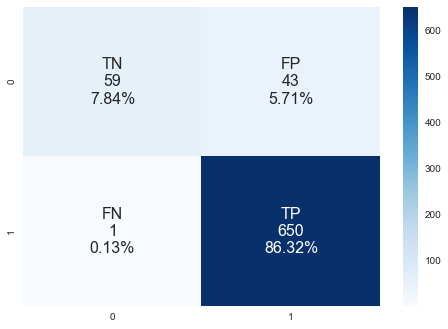

In [37]:
prob = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = prob > 0.5
make_confusion_matrix(y_true, y_pred)

## VGG19

In [ ]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 10,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        class_mode = 'binary',
        batch_size = 753,
        seed = 42,
        shuffle = False)

In [ ]:
vgg19 = VGG19(include_top = False, 
              weights = 'imagenet', 
              input_shape = (224, 224, 3))

model3 = models.Sequential()
model3.add(vgg19)
model3.add(layers.Flatten())
model3.add(layers.Dense(132, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

for layer in model3.layers:
    print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

vgg19.trainable = False

for layer in model3.layers:
    print(layer.name, layer.trainable)
    print(len(model.trainable_weights))

model3.compile(optimizer = Adam(lr=0.001),
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.00001)
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
mcp_save = ModelCheckpoint('../models/VGG19.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min')
tensorboard_cb = TensorBoard(log_dir="../logvgg19")
csv_logger = CSVLogger('../logvgg19/log.csv')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger, lr_reduction],
                     validation_data = val_generator,
                     batch_size = 10)

In [ ]:
plt.style.use('seaborn')
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

<img src="images/vgg19.png">

In [9]:
history3 = pd.read_csv('logvgg19/log.csv')
history3

epoch       acc     auc_6     auc_7      loss  precision_3  recall_3  \
0       0  0.927047  0.938315  0.966305  0.269627     0.941474  0.964080   
1       1  0.950292  0.969664  0.984754  0.151580     0.955618  0.980215   
2       2  0.958480  0.983305  0.992752  0.115991     0.961034  0.985401   
3       3  0.960965  0.983751  0.992659  0.111437     0.965855  0.983481   
4       4  0.970322  0.987496  0.994144  0.093593     0.971181  0.990396   
5       5  0.968275  0.989212  0.995435  0.091284     0.971105  0.987706   
6       6  0.972368  0.988120  0.994316  0.089581     0.974466  0.989627   
7       7  0.975146  0.990905  0.995469  0.074839     0.977980  0.989627   
8       8  0.983918  0.994855  0.997613  0.053829     0.983859  0.995198   
9       9  0.984064  0.994368  0.997220  0.053655     0.985521  0.993661   
10     10  0.982018  0.995724  0.998204  0.053632     0.982899  0.993661   
11     11  0.986257  0.995806  0.997987  0.047657     0.987043  0.995006   
12     12  0.985380  0.995632  0.997937  0.048287     0.985731  0.995198   
13     13  0.990351  0.997127  0.998575  0.036047     0.990084  0.997311   
14     14  0.989327  0.996863  0.998380  0.036074     0.989697  0.996350   
15     15  0.990058  0.997709  0.999008  0.034585     0.990454  0.996542   
16     16  0.991813  0.998463  0.999266  0.027972     0.991600  0.997695   
17     17  0.991082  0.998568  0.999415  0.028053     0.991592  0.996735   
18     18  0.991959  0.998365  0.999233  0.027505     0.992542  0.996927   
19     19  0.992690  0.998651  0.999337  0.025455     0.992549  0.997887   

     val_acc  val_auc_6  val_auc_7  val_loss  val_precision_3  val_recall_3  
0   0.925631   0.945649   0.988398  0.225523         0.969984      0.943164  
1   0.937583   0.954384   0.989048  0.181507         0.942815      0.987711  
2   0.925631   0.962328   0.990697  0.208755         0.977528      0.935484  
3   0.945551   0.965362   0.991503  0.140972         0.947214      0.992320  
4   0.950863   0.965129   0.991145  0.139445         0.969419      0.973886  
5   0.948207   0.965423   0.991560  0.165091         0.947368      0.995392  
6   0.945551   0.955927   0.987372  0.212341         0.943314      0.996928  
7   0.944223   0.954565   0.986899  0.195748         0.944526      0.993856  
8   0.949535   0.956733   0.988683  0.184981         0.985737      0.955453  
9   0.958831   0.955092   0.986995  0.147498         0.968278      0.984639  
10  0.952191   0.959271   0.989032  0.167483         0.984252      0.960061  
11  0.958831   0.952607   0.985669  0.143167         0.976923      0.975422  
12  0.957503   0.956274   0.987343  0.153217         0.968230      0.983103  
13  0.958831   0.955641   0.986864  0.155511         0.976923      0.975422  
14  0.957503   0.953676   0.986173  0.159136         0.979845      0.970814  
15  0.956175   0.959128   0.988250  0.164292         0.965361      0.984639  
16  0.958831   0.956402   0.987108  0.154854         0.974006      0.978495  
17  0.958831   0.954309   0.986197  0.169964         0.981366      0.970814  
18  0.962815   0.957313   0.987450  0.157374         0.977029      0.980031  
19  0.956175   0.952893   0.985451  0.177018         0.982813      0.966206

In [ ]:
plt.style.use('seaborn')
train_val_metrics(20, history3)

<img src="images/vgg19_loss_acc.png">

In [ ]:
# prob3 = model3.predict_generator(test_generator)
# y_true = test_generator.classes
# y_pred3 = prob3 > 0.5
# make_confusion_matrix(y_true, y_pred3)

<img src="images/vgg19_cf.png">

In [ ]:
y_score = model3.predict_proba(X_tt)
fpr, tpr, __ = roc_curve(y_tt, y_score)
roc_auc = auc(fpr, tpr)
prec,rec, __ = precision_recall_curve(y_tt, y_score)
pr_auc = auc(rec, prec)

plt.figure(figsize = [9, 6])
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot(rec, prec, label = 'PR curve (area = %0.2f)' % pr_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Binary Classification of Skin Lesions', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()

<img src="images/vgg19_auc.png">

# Amazon Sagemaker Instances

I will continue to work on those models through Amazon Sagemaker with the entire dataset to obtain the best model based on the entire image dataset.

# Flutter Implementation

I will work on implementing this algorithm into an app platform with Flutter.